# Linear Model Testing & Evaluation

In [30]:
# Dependencies
import pandas as pd
from sklearn.feature_selection import VarianceThreshold
from sklearn import preprocessing
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, Lasso
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
import numpy as np
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
import math
import seaborn as sns
import pickle

In [12]:
# Location files
features_loc = "../dataset/train_feat_cleaned.pickle"
target_loc = "../dataset/train_target_cleaned.pickle"

In [13]:
features_df = pd.read_pickle(features_loc)
target_df = pd.read_pickle(target_loc)

In [14]:
target_df[target_df["PERMA"].isna()]

,id,gender,born,education,employed,income,A_2,N_1,P_1,E_1,...,P,E,R,M,A,PERMA,N_EMO,P_EMO,imagecount,private_account


In [15]:
target_df.columns

Index(['id', 'gender', 'born', 'education', 'employed', 'income', 'A_2', 'N_1',
       'P_1', 'E_1', 'A_1', 'H_1', 'M_1', 'R_1', 'M_2', 'E_2', 'LON', 'H_2',
       'P_2', 'N_2', 'A_3', 'N_3', 'E_3', 'H_3', 'R_2', 'M_3', 'R_3', 'P_3',
       'HAP', 'participate', 'insta_user_id', 'completed', 'start_q', 'end_q',
       'network_id', 'P', 'E', 'R', 'M', 'A', 'PERMA', 'N_EMO', 'P_EMO',
       'imagecount', 'private_account'],
      dtype='object')

In [16]:
# Create vector for columns of questions
questions = list(target_df.columns[6:29])
questions.remove('LON')
questions = [q for q in questions if q not in ('LON', 'N_1', 'N_2', 'N_3','H_1', 'H_2', 'H_3')]
questions.sort()
print(questions)

['A_1', 'A_2', 'A_3', 'E_1', 'E_2', 'E_3', 'HAP', 'M_1', 'M_2', 'M_3', 'P_1', 'P_2', 'P_3', 'R_1', 'R_2', 'R_3']


In [17]:
# Check if all individual questions aa up to the PERMA score
(target_df[questions].mean(axis = 1) == target_df["PERMA"]).mean()

1.0

In [18]:
# Check missing values
print(features_df.isnull().sum().sum(), 
      target_df.isnull().sum().sum())

0 0


In [19]:
# Basic linear model with all features

# Create training and test sets
X_train, X_test, y_train, y_test = train_test_split(features_df, target_df["PERMA"], test_size = 0.20, random_state=10)

# Create the regressor: reg_all
reg_all = LinearRegression()

# Fit the regressor to the training data
reg_all.fit(X_train, y_train)

# Predict on the test data: y_pred
y_pred = reg_all.predict(X_test)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_all.score(X_test, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))


R^2: -10.927265437882015
Root Mean Squared Error: 5.2467510252009815


Full model gets a negative r^2, so reaaly bad.

In [20]:
# Try a number of times using Cross validation
# Not for report

# Create a linear regression object: reg
reg = LinearRegression()

# Compute 5-fold cross-validation scores: cv_scores
cv_scores = cross_val_score(reg, features_df, target_df["PERMA"], cv = 5)

# Print the 5-fold cross-validation scores
print(cv_scores)

print("Average 5-Fold CV Score: {}".format(np.mean(cv_scores)))


[-2.76076007e-01 -2.36915666e-01 -2.93657569e-01 -5.26735819e-01
 -3.08564641e+02]
Average 5-Fold CV Score: -61.979605236923234


In [21]:
# Trying a Lasso Regression
X = features_df
y = target_df["PERMA"]

a_space = np.linspace(0.01, 1, 100)
param_grid = {'alpha': a_space}
# Instantiate a lasso regressor: lasso
lasso = Lasso()

# Instantiate the GridSearchCV object: logreg_cv
lasso_cv = GridSearchCV(lasso, param_grid, cv=10)

# Fit the regressor to the data
lasso_cv.fit(X, y)

# Print the tuned parameters and score
print("Tuned Logistic Regression Parameters: {}".format(lasso_cv.best_params_)) 
print("Best score is {}".format(lasso_cv.best_score_))


Tuned Logistic Regression Parameters: {'alpha': 0.06999999999999999}
Best score is -0.07493866113553516


/Users/Joris/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:814: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [22]:
# Use MLXtend package to automaticly do forward feature selection

X = features_df
y = target_df["PERMA"]

lr = LinearRegression()

sfs = SFS(lr, 
          k_features="best", 
          forward=True, 
          floating=False, 
          scoring='r2',
          cv=10)

sfs = sfs.fit(X, y)

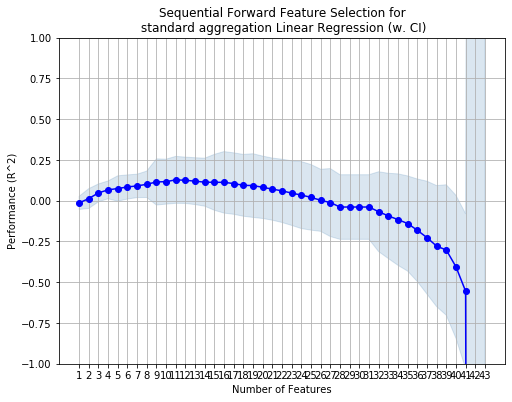

In [40]:
fig = plot_sfs(sfs.get_metric_dict(), kind='ci', figsize= (8,6))
plt.ylim(-1,1)
plt.title('Sequential Forward Feature Selection for\n standard aggregation Linear Regression (w. CI)')
plt.ylabel("Performance (R^2)")
plt.grid()
# plt.show()
plt.savefig("../images/LR_Forward_Selection.png")

In [24]:
best_feat = list(sfs.k_feature_names_)
print("Amount chosen", len(sfs.k_feature_idx_),
    "CV score:", sfs.k_score_,
      
    "Best features:", *best_feat, sep = "\n")
pd.DataFrame.from_dict(sfs.get_metric_dict()).T

Amount chosen
10
CV score:
0.1581231475884441
Best features:
data_memorability
face_emotion_CALM
face_emotion_CONFUSED
face_emotion_SURPRISED
male
emotion_label_acceptance
emotion_label_rage
emotion_label_sadness
emotion_label_serenity
emotion_label_terror


,feature_idx,cv_scores,avg_score,feature_names,ci_bound,std_dev,std_err
1,"(36,)","[0.04627949378560514, 0.0352261223865199, -0.0...",-0.0166715,"(emotion_label_rage,)",0.0655482,0.088255,0.0294183
2,"(11, 36)","[0.07908154341884432, 0.11079008038824945, -0....",0.0157638,"(face_emotion_SURPRISED, emotion_label_rage)",0.0945456,0.127298,0.0424325
3,"(11, 36, 40)","[0.09509738404547985, 0.2223989001453004, -0.0...",0.0302235,"(face_emotion_SURPRISED, emotion_label_rage, e...",0.107546,0.144801,0.0482671
4,"(11, 19, 36, 40)","[0.12592660614954498, 0.17691707160892078, -0....",0.0523776,"(face_emotion_SURPRISED, emotion_label_accepta...",0.133623,0.179912,0.0599707
5,"(7, 11, 19, 36, 40)","[0.1486791368399274, 0.30251349786932913, -0.0...",0.0730996,"(face_emotion_CALM, face_emotion_SURPRISED, em...",0.142449,0.191796,0.0639318
6,"(7, 11, 19, 36, 37, 40)","[0.16153635506099873, 0.2979850668171721, 0.04...",0.0925751,"(face_emotion_CALM, face_emotion_SURPRISED, em...",0.143368,0.193033,0.0643444
7,"(1, 7, 11, 19, 36, 37, 40)","[0.18547278864007988, 0.32409506795254595, 0.0...",0.120282,"(data_memorability, face_emotion_CALM, face_em...",0.127436,0.171582,0.0571941
8,"(1, 7, 11, 15, 19, 36, 37, 40)","[0.14705972515845245, 0.44013728487215786, 0.0...",0.137124,"(data_memorability, face_emotion_CALM, face_em...",0.123562,0.166365,0.0554551
9,"(1, 7, 11, 15, 19, 36, 37, 38, 40)","[0.17988317769277373, 0.45450270019345007, 0.0...",0.155582,"(data_memorability, face_emotion_CALM, face_em...",0.117852,0.158677,0.0528925
10,"(1, 7, 8, 11, 15, 19, 36, 37, 38, 40)","[0.19296597369141577, 0.4806698646131242, 0.10...",0.158123,"(data_memorability, face_emotion_CALM, face_em...",0.117669,0.158432,0.0528106


In [25]:
# Evaluate best single model

# Create training and test sets
X_train_best, X_test_best, y_train, y_test = train_test_split(features_df[best_feat], target_df["PERMA"]
                                                    , test_size = 0.30, random_state=42)

# Create the regressor: reg_all
reg_best = LinearRegression()

# Fit the regressor to the training data
reg_best.fit(X_train_best, y_train)

# Predict on the test data: y_pred
y_pred = reg_best.predict(X_test_best)

# Compute and print R^2 and RMSE
print("R^2: {}".format(reg_best.score(X_test_best, y_test)))
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.15630528430800028
Root Mean Squared Error: 1.1874107866378678


In [26]:
# Create compound model of 6 perma score elements
perma_elements = ["P", "E", "R", "M", "A", "HAP"]

best_features = dict()

for question in perma_elements:
    lr = LinearRegression()
    sfs = SFS(lr, 
              k_features="best", 
              forward=True, 
              floating=False, 
              scoring='r2',
              cv=10)
    sfs = sfs.fit(features_df, target_df[question])
    best_features[question] = (sfs.k_score_, sfs.k_feature_names_)

In [27]:
list(best_features["P"][1])

['image_width',
 'data_memorability',
 'user_posted_photos',
 'face_emotion_CALM',
 'face_emotion_CONFUSED',
 'face_emotion_SURPRISED',
 'male',
 'emotion_label_acceptance',
 'emotion_label_annoyance',
 'emotion_label_ecstasy',
 'emotion_label_grief',
 'emotion_label_joy',
 'emotion_label_rage',
 'emotion_label_serenity',
 'emotion_label_terror']

In [28]:
# Evaluate compound model

# Create training and test sets
X_train_flex, X_test_flex, y_train_flex, y_test_flex = train_test_split(features_df, target_df
                                                    , test_size = 0.30, random_state=69)
predicted_data = pd.DataFrame()
models = dict()

for element in perma_elements:
    # Create the regressor: lr
    lr = LinearRegression()

    # Extract the best features for the element
    features = list(best_features[element][1])
    
    # Fit the regressor to the training data
    lr.fit(X_train_flex[features], y_train_flex[element])

    # Predict on the test data: y_pred
    y_pred = lr.predict(X_test_flex[features])
  
    predicted_data[element] = y_pred
    models[element] = lr
    
predicted_data["PERMA"] = predicted_data.mean(1)


# Compute and print R^2 and RMSE
print("R^2: {}".format(r2_score(y_test_flex["PERMA"], predicted_data["PERMA"].values)))
rmse = np.sqrt(mean_squared_error(y_test_flex["PERMA"], predicted_data["PERMA"].values))
print("Root Mean Squared Error: {}".format(rmse))

R^2: 0.2927484572105994
Root Mean Squared Error: 1.3092132273083377


In [31]:
# Save total model to pickle
pickle.dump(reg_all, open("../models/reg_all", 'wb'))
# Save best single model to pickle
pickle.dump(best_feat, open("../models/best_feat", 'wb'))
pickle.dump(reg_best, open("../models/reg_best", 'wb'))
# Save compound model to pickle
pickle.dump(best_features, open("../models/comp_features.pickle", 'wb'))
pickle.dump(models, open("../models/perma_el.pickle", 'wb'))
pickle.dump(perma_elements, open("../models/compound.pickle", 'wb'))

#### Dataset size & random seed discussion
Due to small size of the dataset and thus a small test dataset the RMSE & R^2 are heavily dependent on the random seed. Different seed choices result in large variations of the two statistics mentioned. To-Do: plot difference in statistic values per random_state in say...two or three regressors, 10 or 15 random_state values.

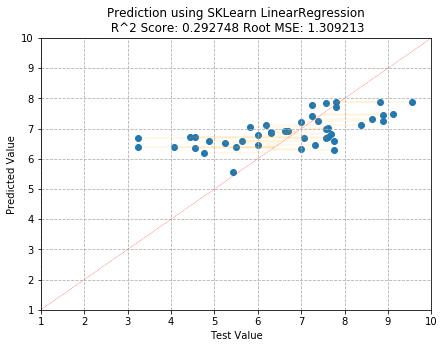

In [32]:
fig = plt.figure(figsize=(7,5))
xl = plt.xlim(1, 10)
yl = plt.ylim(1, 10)

ax = plt.gca()
ax.set_xlabel('Test Value')
ax.set_ylabel('Predicted Value')
plt.title('Prediction using SKLearn LinearRegression\n R^2 Score: %f Root MSE: %f'\
% (r2_score(y_test_flex["PERMA"], predicted_data["PERMA"].values),\
np.sqrt(mean_squared_error(y_test_flex["PERMA"], predicted_data["PERMA"].values))))

plt.scatter(x=y_test_flex["PERMA"], y=predicted_data["PERMA"])
plt.plot(xl, yl, '--', color='r',linewidth=0.3)
ax.hlines(y=predicted_data["PERMA"], xmin=predicted_data["PERMA"], xmax=y_test_flex["PERMA"], color='orange', linestyle='dotted', linewidth=0.4)
plt.grid(linestyle='--')
plt.savefig('../images/regression/SKL_LR_fig1.png', format='png')
plt.show()


In [33]:
print(y_test_flex["PERMA"].max() - predicted_data["PERMA"].max())
print(y_test_flex["PERMA"].min() - predicted_data["PERMA"].min())

for foo in zip(y_test_flex["PERMA"], predicted_data["PERMA"]):
    print(foo[0] - foo[1])




1.665450018748639
-2.3150215767621605
-0.46869798137030827
0.9132130035187771
-1.442891349851263
-0.5731343917672618
-0.1686793837613827
1.6293578763557761
-3.4489202723637957
-2.1598128117855415
-0.2969888466024342
-0.9478565477965271
0.6757845942204765
-0.24007789011008196
0.6042978265703347
-1.7274194653452648
-0.8961589612001859
-0.5365295171508349
-3.1372532059692375
0.8600349941305936
0.13279406076425548
-1.788780798928225
1.3146880968655585
-0.9731792925349163
1.6550248225159292
0.8752656129494971
1.1566681666430476
0.5693210495444996
0.915450018748639
-2.3390367511306343
1.4349384294821794
-0.12752157676216047
-1.2613525397070093
1.665518964922203
-0.7779685566874557
0.3824768013613351
0.8575823055222793
-0.28564671251140883
-0.5506523201781564
-0.07218719733126022
-2.2809921087273706
-1.2352926751551196
0.08312787700041735
1.4574521753682994
1.263374706781537
-0.2120018899570857


#### Testing with an SVM

Some notes: the SVM benifits from as much training data as it can get. I gave it 90% to eat.
In testing for the target of the highest possible R^2 combined with the lowest possible MSE, I iterated over a range of C=0.7-1.3 and e=0.0-0.3 where C is the penalty for falling outside the epsilon tube and e is the radius of the tube.

In [37]:
# Evaluate compound model with an SVM

# Create training and test sets
X_train_flex, X_test_flex, y_train_flex, y_test_flex = train_test_split(features_df, target_df
                                                    , test_size = 0.10, random_state=69)
predicted_data = pd.DataFrame()
models_svm = dict()

for element in perma_elements:
    # Create the regressor: SVR
    clf = SVR(kernel='linear', gamma='scale', C=1.3, epsilon=0)

    # Extract the best features for the element
    features = list(best_features[element][1])
    
    # Fit the regressor to the training data
    clf.fit(X_train_flex[features], y_train_flex[element])

    # Predict on the test data: y_pred
    y_pred = clf.predict(X_test_flex[features])
    
    models_svm[element] = clf
  
    predicted_data[element] = y_pred
    
predicted_data["PERMA"] = predicted_data.mean(1)

# Compute and print R^2 and RMSE
print("R^2: {}".format(r2_score(y_test_flex["PERMA"], predicted_data["PERMA"].values)))
rmse = np.sqrt(mean_squared_error(y_test_flex["PERMA"], predicted_data["PERMA"].values))
print("Root Mean Squared Error: {}".format(rmse))

R^2: -0.15709179718665567
Root Mean Squared Error: 1.540468306780597


In [38]:
# Save compound model to pickle
pickle.dump(models_svm, open("../models/models_svm.pickle", 'wb'))

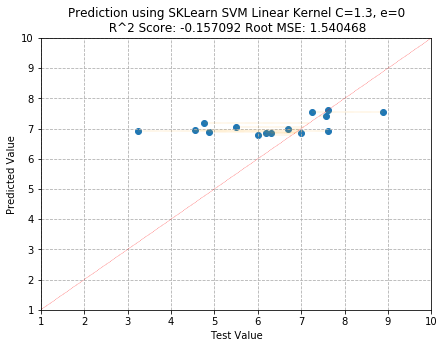

In [35]:
fig = plt.figure(figsize=(7,5))
xl = plt.xlim(1, 10)
yl = plt.ylim(1, 10)

ax = plt.gca()
ax.set_xlabel('Test Value')
ax.set_ylabel('Predicted Value')
plt.title('Prediction using SKLearn SVM Linear Kernel C=1.3, e=0\n \
R^2 Score: %f Root MSE: %f' % (r2_score(y_test_flex["PERMA"],\
predicted_data["PERMA"].values), np.sqrt(mean_squared_error(y_test_flex["PERMA"], \
predicted_data["PERMA"].values))))

ax.scatter(x=y_test_flex["PERMA"], y=predicted_data["PERMA"])
ax.plot(xl, yl, '--', color='r',linewidth=0.3)
ax.hlines(y=predicted_data["PERMA"], xmin=predicted_data["PERMA"], xmax=y_test_flex["PERMA"], color='orange', linestyle='dotted', linewidth=0.4)
ax.grid(linestyle='--')
plt.savefig('../images/regression/SKL_SVM_LK_fig1.png', format='png')
plt.show()


# Old stuff, ignore for now

In [ ]:
# # Scale data
# scaler = preprocessing.StandardScaler()
# features_df_scaled = features_df.copy()
# features_df_scaled[features_df_scaled.columns] = scaler.fit_transform(
#     features_df_scaled[features_df_scaled.columns])

# normalizer = preprocessing.Normalizer()
# features_df_norm = features_df.copy()
# features_df_norm[features_df_norm.columns] = scaler.fit_transform(
#     features_df_norm[features_df_norm.columns])

# features_df_n=((features_df-features_df.min())/(features_df.max()-features_df.min()))

# plt.plot(features_df_n.std())
# Check variance
# sel = VarianceThreshold(threshold=(.8 * (1 - .8)))
# sel.fit_transform(X)
features_df.shape

In [ ]:
# the intercept is the expected mean of the perma score if some X is equal to 0
# in our case, it's pretty low
print('Estimated intercept coefficient:', lr.intercept_)

# the number of coefficients
print('Number of coefficients:', len(lr.coef_))

# output the coefficients
pd.DataFrame(list(zip(X_train_flex.columns, lr.coef_)), columns = ['features', 'estimatedCoefficients'])

The coefficient of the **glasses** feature, is significantly higher than all other features. We can use a residential plot to see if the this feature is suitable for linear regression.

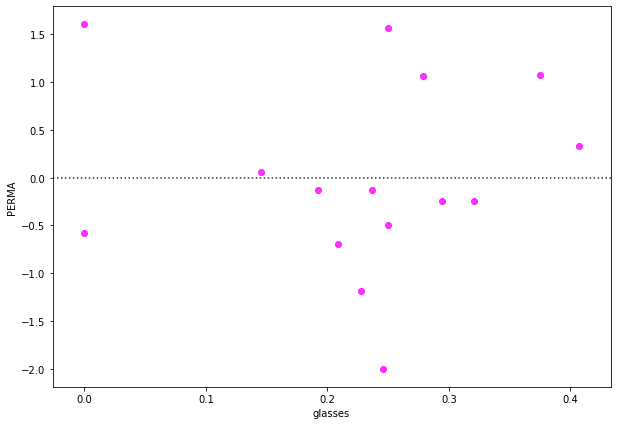

In [24]:
fig = plt.figure(figsize=(10,7))
sns.residplot(X_test_flex.glasses, y_test_flex.PERMA, color='magenta')

Plot a scatter plot using the **glasses** feature and the **PERMA** scores from the test -and predicted dataset.

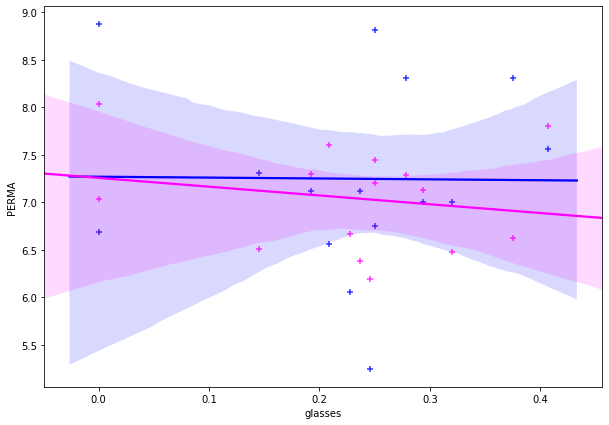

In [25]:
fig = plt.figure(figsize=(10,7))
ax1 = sns.regplot(x=X_test_flex.glasses,y=y_test_flex.PERMA,color='blue', marker='+')
sns.regplot(x=X_test_flex.glasses,y=y_pred,color='magenta', marker='+', ax=ax1)

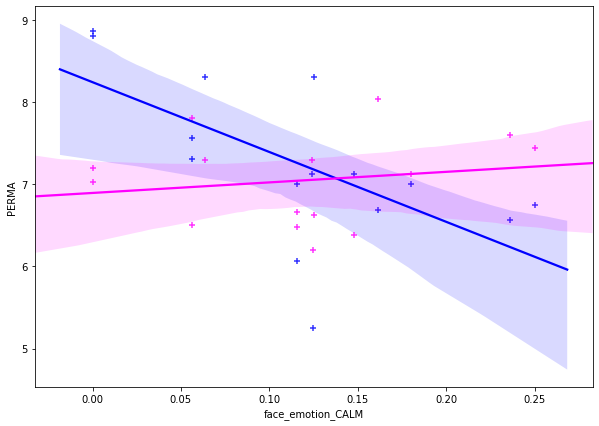

In [26]:
# try to do the same for the CALM emotion
fig = plt.figure(figsize=(10,7))
ax1 = sns.regplot(x=X_test_flex.face_emotion_CALM,y=y_test_flex.PERMA,color='blue', marker='+')
sns.regplot(x=X_test_flex.face_emotion_CALM,y=y_pred,color='magenta', marker='+', ax=ax1)

['data_memorability', 'face_emotion_CALM', 'face_emotion_CONFUSED', 'face_emotion_SURPRISED', 'male', 'emotion_label_acceptance', 'emotion_label_rage', 'emotion_label_sadness', 'emotion_label_serenity', 'emotion_label_terror']


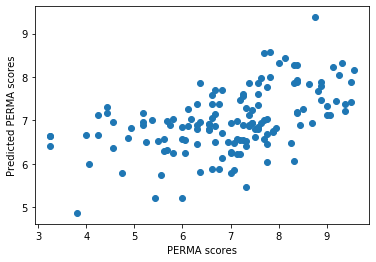

In [27]:
print(best_feat)
plt.scatter(target_df.PERMA, reg_best.predict(features_df[best_feat]))
plt.xlabel('PERMA scores')
plt.ylabel('Predicted PERMA scores')
plt.show()